In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [15]:
X = np.loadtxt('lista01/ImageRawReduced.txt')  # 3 x 9350
C = np.loadtxt('lista01/ImageExpertReduced.txt', dtype=int)  # 1 x 9350
Rules = np.loadtxt('lista01/ClassificationRules.txt', dtype=int)  # 266 x 9350
full_C = np.loadtxt('lista01/ImageExpert.txt', dtype=int)  # 1 x 15688

C:\Users\szcze\AppData\Local\Temp\ipykernel_40636\708822460.py:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  C = np.loadtxt('lista01/ImageExpertReduced.txt', dtype=int)  # Wektor 1 x 9350
C:\Users\szcze\AppData\Local\Temp\ipykernel_40636\708822460.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np

In [16]:
n_iter = 1000
pop_size = 500  
d = 266  
lr = 0.15 
nr = 0.03  
mut_rate = 0.02  
mut_size = 0.03  

PBIL runner

In [17]:
P = np.full(d, 0.5)
last_100_average = np.zeros(100)

best_fitness_over_time = []
for iter in range(n_iter):
    population = np.zeros((pop_size, d), dtype=int)
    fitness = np.zeros(pop_size)
    
    for i in range(pop_size):
        individual = np.random.rand(d) < P
        population[i] = individual.astype(int)
        
        selected_rules = Rules[individual == 1]
        if selected_rules.size == 0:
            fitness[i] = 0
            continue
        
        votes = selected_rules.T  
        predictions = np.apply_along_axis(lambda x: np.bincount(x, minlength=4)[1:].argmax()+1, axis=1, arr=votes)
        
        fitness[i] = np.sum(predictions == C) #ask: how would we calculate it if we didnt have C?
    
    best_idx = np.argmax(fitness)
    worst_idx = np.argmin(fitness)
    best_individual = population[best_idx]
    worst_individual = population[worst_idx]
    
    P = P * (1 - lr) + best_individual * lr
    P = P * (1 - nr) + worst_individual * nr
    
    mutation = np.random.rand(d) < mut_rate
    P[mutation] = P[mutation] * (1 - mut_size) + np.random.rand(np.sum(mutation)) * mut_size
    
    P = np.clip(P, 0, 1)
    
    best_accuracy = fitness[best_idx] / len(C) * 100
    best_fitness_over_time.append(best_accuracy)

    mean_before = np.mean(last_100_average)
    last_100_average = last_100_average[1:]
    last_100_average = np.append(last_100_average, best_accuracy)
    
    print(f"Iteracja {iter+1}/{n_iter}, najlepsza dokładność: {best_accuracy:.2f}%")
    if(np.mean(last_100_average) <= mean_before):
        break

Iteracja 1/1000, najlepsza dokładność: 93.84%
Iteracja 2/1000, najlepsza dokładność: 94.59%
Iteracja 3/1000, najlepsza dokładność: 95.70%
Iteracja 4/1000, najlepsza dokładność: 95.57%
Iteracja 5/1000, najlepsza dokładność: 96.75%
Iteracja 6/1000, najlepsza dokładność: 96.61%
Iteracja 7/1000, najlepsza dokładność: 96.46%
Iteracja 8/1000, najlepsza dokładność: 96.96%
Iteracja 9/1000, najlepsza dokładność: 97.41%
Iteracja 10/1000, najlepsza dokładność: 97.51%
Iteracja 11/1000, najlepsza dokładność: 97.30%
Iteracja 12/1000, najlepsza dokładność: 97.37%
Iteracja 13/1000, najlepsza dokładność: 97.59%
Iteracja 14/1000, najlepsza dokładność: 97.74%
Iteracja 15/1000, najlepsza dokładność: 97.72%
Iteracja 16/1000, najlepsza dokładność: 97.81%
Iteracja 17/1000, najlepsza dokładność: 97.88%
Iteracja 18/1000, najlepsza dokładność: 97.90%
Iteracja 19/1000, najlepsza dokładność: 97.95%
Iteracja 20/1000, najlepsza dokładność: 98.10%
Iteracja 21/1000, najlepsza dokładność: 98.09%
Iteracja 22/1000, najl

[1 2 1 ... 3 3 3]

Końcowa dokładność: 98.59%


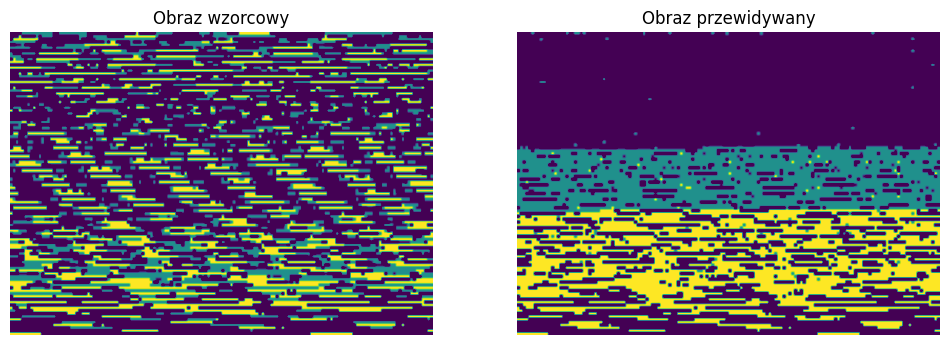

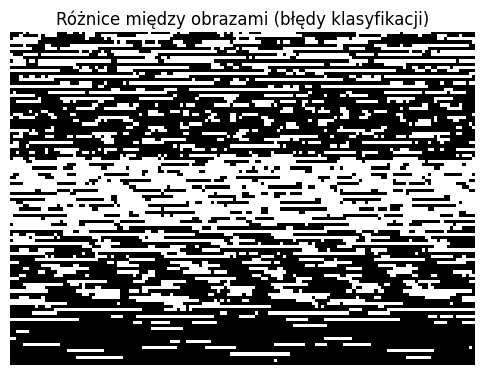

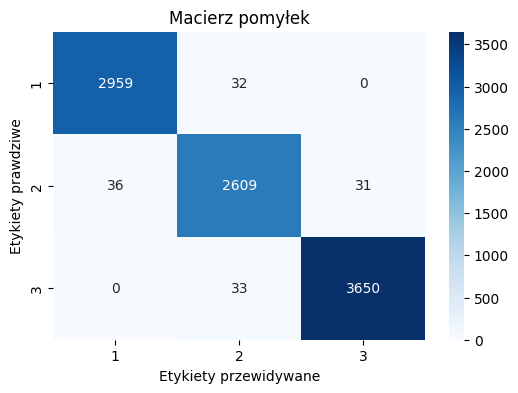

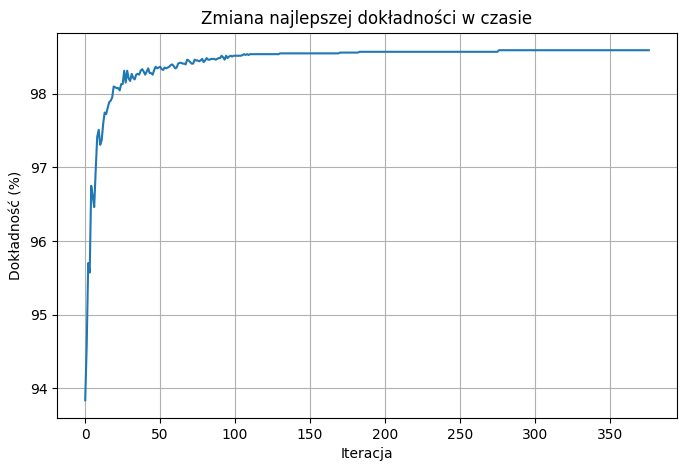

In [20]:
final_individual = (P > 0.5).astype(int)
final_individual = (P > 0.5).astype(int)
selected_rules_indices = np.where(final_individual == 1)[0]
selected_rules = Rules[selected_rules_indices]

votes = selected_rules.T  # 9350 x 3

def majority_vote(v):
    counts = np.bincount(v, minlength=4)[1:]
    return counts.argmax() + 1

predictions = np.apply_along_axis(majority_vote, 1, votes)
print(predictions)

final_accuracy = np.sum(predictions == C) / len(C) * 100
print(f"\nKońcowa dokładność: {final_accuracy:.2f}%")

original_classes = [3, 7, 9]
reduced_classes = [1, 2, 3]
class_mapping = dict(zip(original_classes, reduced_classes))
inverse_class_mapping = dict(zip(reduced_classes, original_classes))
mask = np.isin(full_C, original_classes)

full_C_reduced = np.zeros_like(full_C)
full_C_reduced[mask] = [class_mapping[c] for c in full_C[mask]]

full_predictions = np.zeros_like(full_C)
full_predictions[mask] = predictions

height = 106
width = 148

image_expert = full_C_reduced.reshape(height, width)
image_predicted = full_predictions.reshape(height, width)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_expert, cmap='viridis', vmin=1, vmax=3)
plt.title('Obraz wzorcowy')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_predicted, cmap='viridis', vmin=1, vmax=3)
plt.title('Obraz przewidywany')
plt.axis('off')

plt.show()

difference = (image_expert != image_predicted).astype(int)

plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap='gray')
plt.title('Różnice między obrazami (błędy klasyfikacji)')
plt.axis('off')
plt.show()

conf_matrix = confusion_matrix(C, predictions, labels=[1, 2, 3])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.ylabel('Etykiety prawdziwe')
plt.xlabel('Etykiety przewidywane')
plt.title('Macierz pomyłek')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(best_fitness_over_time)
plt.title('Zmiana najlepszej dokładności w czasie')
plt.xlabel('Iteracja')
plt.ylabel('Dokładność (%)')
plt.grid(True)
plt.show()

In [22]:
print(final_individual)

[0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1
 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0
 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 0 0 1 1]
